## Imports

In [1]:
import sys

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
from deep_q_learning import getParams
from deep_q_learning.trainer import Trainer

## Run experiments

In [2]:
evaluated_runs = [
    ('NAIVE',None),
    ('BINARY','models/country_wide_binary_agent12_08.22_12_08.pkl'),
    ('BINARY_TOGGLE','models/country_wide_binary_toggle_agent12_08.22_33_49.pkl'),
    ('MULTI_TOGGLE','models/country_wide_multiaction_toggle_agent12_08.22_33_49.pkl'),
    ('MULTI_FACTORIZED','models/country_wide_multiaction_factorized_agent12_08.23_28_30.pkl'),

]

def _eval(params_path, ev_weights, iterations):
    _params = getParams(params_path)
    return Trainer.evaluate(_params, ev_weights, eval_iterations = iterations)
    
iterations = 100
run_logs = {
    params[1]:_eval(*params,iterations) for params in evaluated_runs
}

## Evaluate the experiments

In [8]:
%matplotlib inline
def extract_log_parameters(log):
    deaths = [e['info_hist'][-1]['parameters']['total']['dead'] for e in log]
    suceptible = [e['info_hist'][-1]['parameters']['total']['recovered'] for e in log]
    confined_days = [np.sum([int(d['action']['confinement']) for d in rlog['info_hist']]) for rlog in log]
    isolated_days = [np.sum([int(d['action']['isolation']) for d in rlog['info_hist']]) for rlog in log]
    hospital_days = [np.sum([int(d['action']['hospital']) for d in rlog['info_hist']]) for rlog in log]
    vaccination_days = [np.sum([int(d['action']['vaccinate']) for d in rlog['info_hist']]) for rlog in log]
    rewards = [np.mean(rlog['R_hist']) for rlog in log]
    return {
        'rewards':rewards,
        'deaths':deaths,
        'suceptible':suceptible,
        'confined_days':confined_days,
        'isolated_days':isolated_days,
        'hospital_days':hospital_days,
        'vaccination_days':vaccination_days,
    }
    

def show_parameter_hist(parameters, select):
    fig, ax = plt.subplots(len(parameters),1,sharex=True,  figsize=(15,15))
    keys = list(parameters.keys())
    vals = list(parameters.values())
    for _id,  val in enumerate(vals):
        ax[_id].set_title(keys[_id])
        ax[_id].hist(val[select], bins=10)
        ax[_id].vlines([np.mean(val[select])],0,50,color='red')
        ax[_id].set_ylim(0,50)
        print(f'{keys[_id]} : average reward = {np.mean(val[select])}')
    plt.suptitle(select)
    plt.tight_layout()
    plt.show()
    

COUNTRY_WIDE_NAIVE : average reward = -1.5234678983688354
COUNTRY_WIDE_BINARY : average reward = 1.0193455219268799
COUNTRY_WIDE_BINARY_TOGGLE : average reward = 0.6740520000457764
COUNTRY_WIDE_MULTI_TOGGLE : average reward = 2.7923364639282227
COUNTRY_WIDE_MULTI_FACTORIZED : average reward = 2.4684174060821533


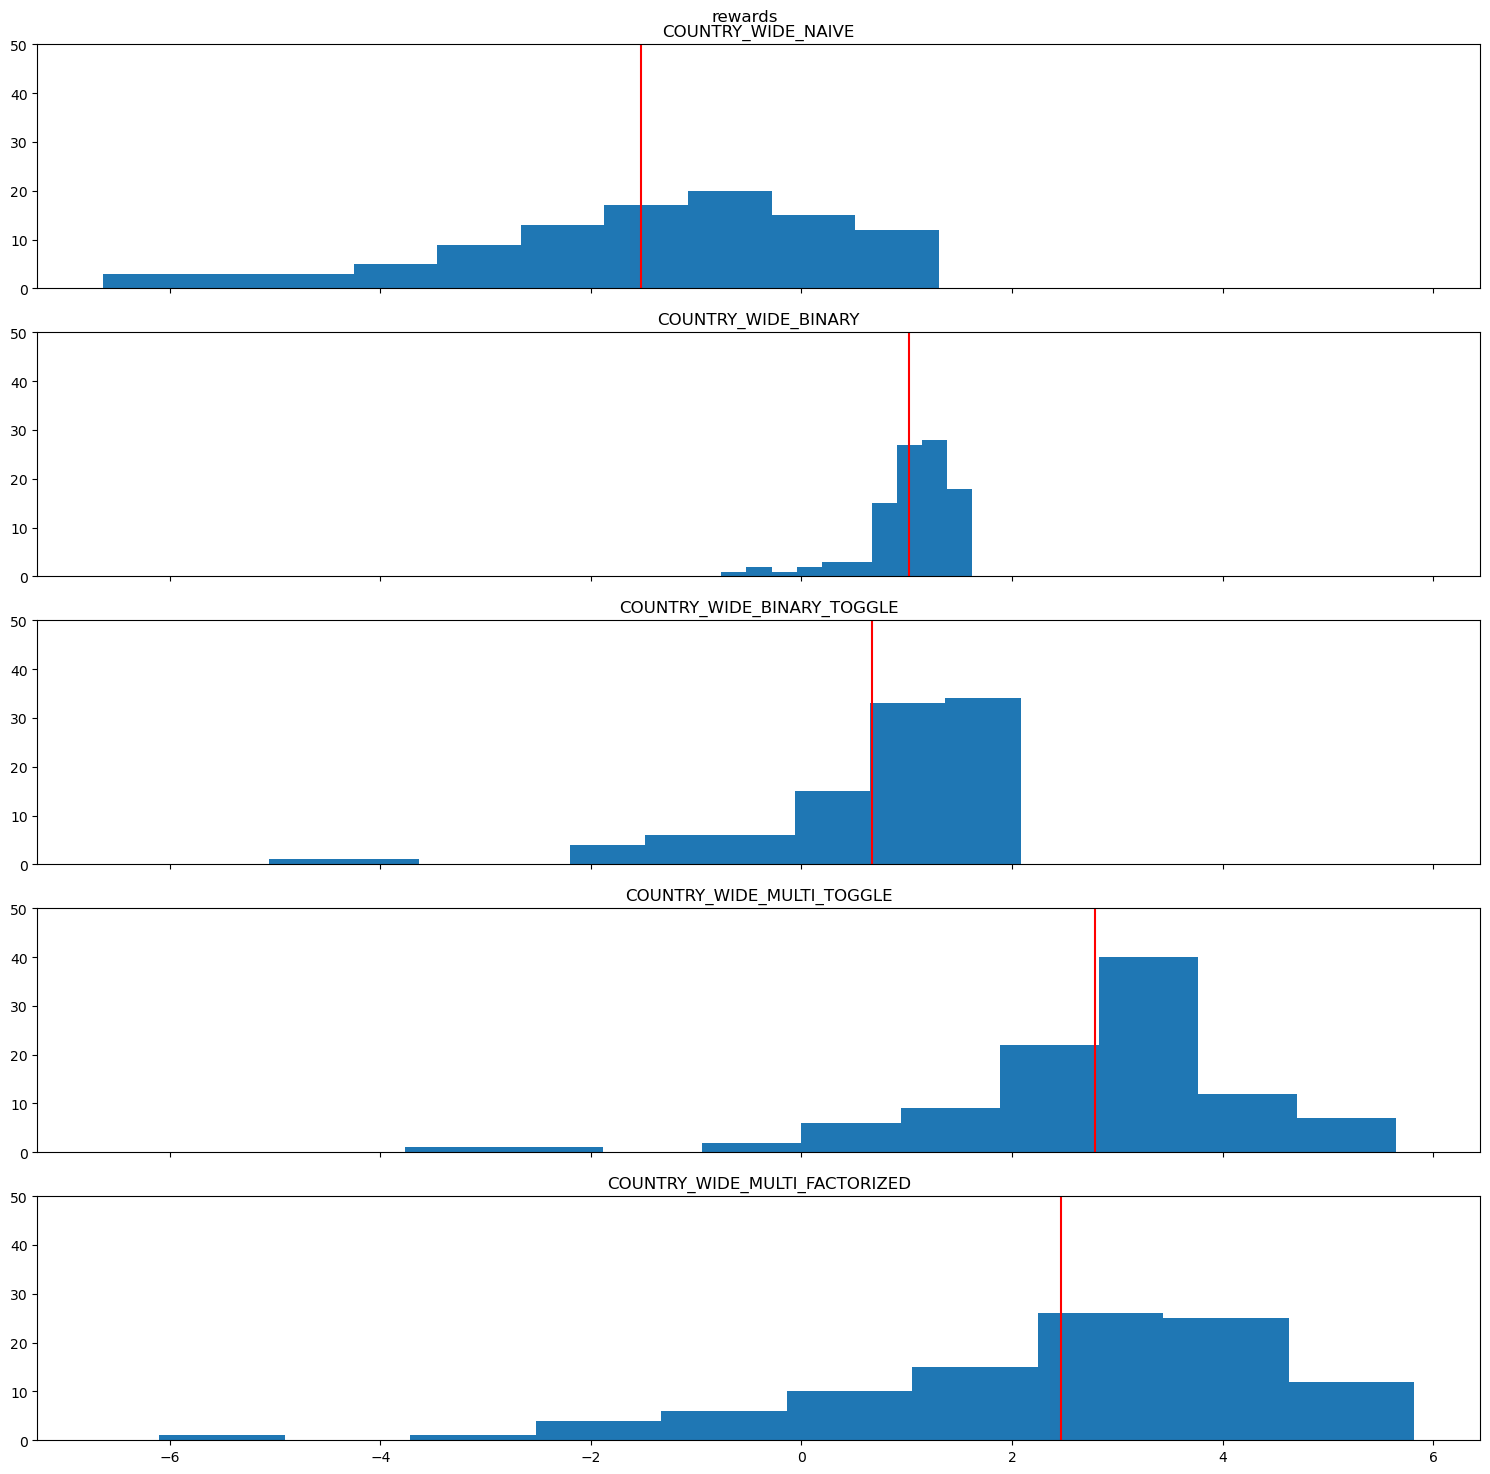

In [9]:
parameters = {key:extract_log_parameters(val) for key, val in run_logs.items()}
show_parameter_hist(parameters,'rewards') 

COUNTRY_WIDE_NAIVE : average reward = 52211.9
COUNTRY_WIDE_BINARY : average reward = 3766.44
COUNTRY_WIDE_BINARY_TOGGLE : average reward = 14546.73
COUNTRY_WIDE_MULTI_TOGGLE : average reward = 25769.09
COUNTRY_WIDE_MULTI_FACTORIZED : average reward = 45102.89


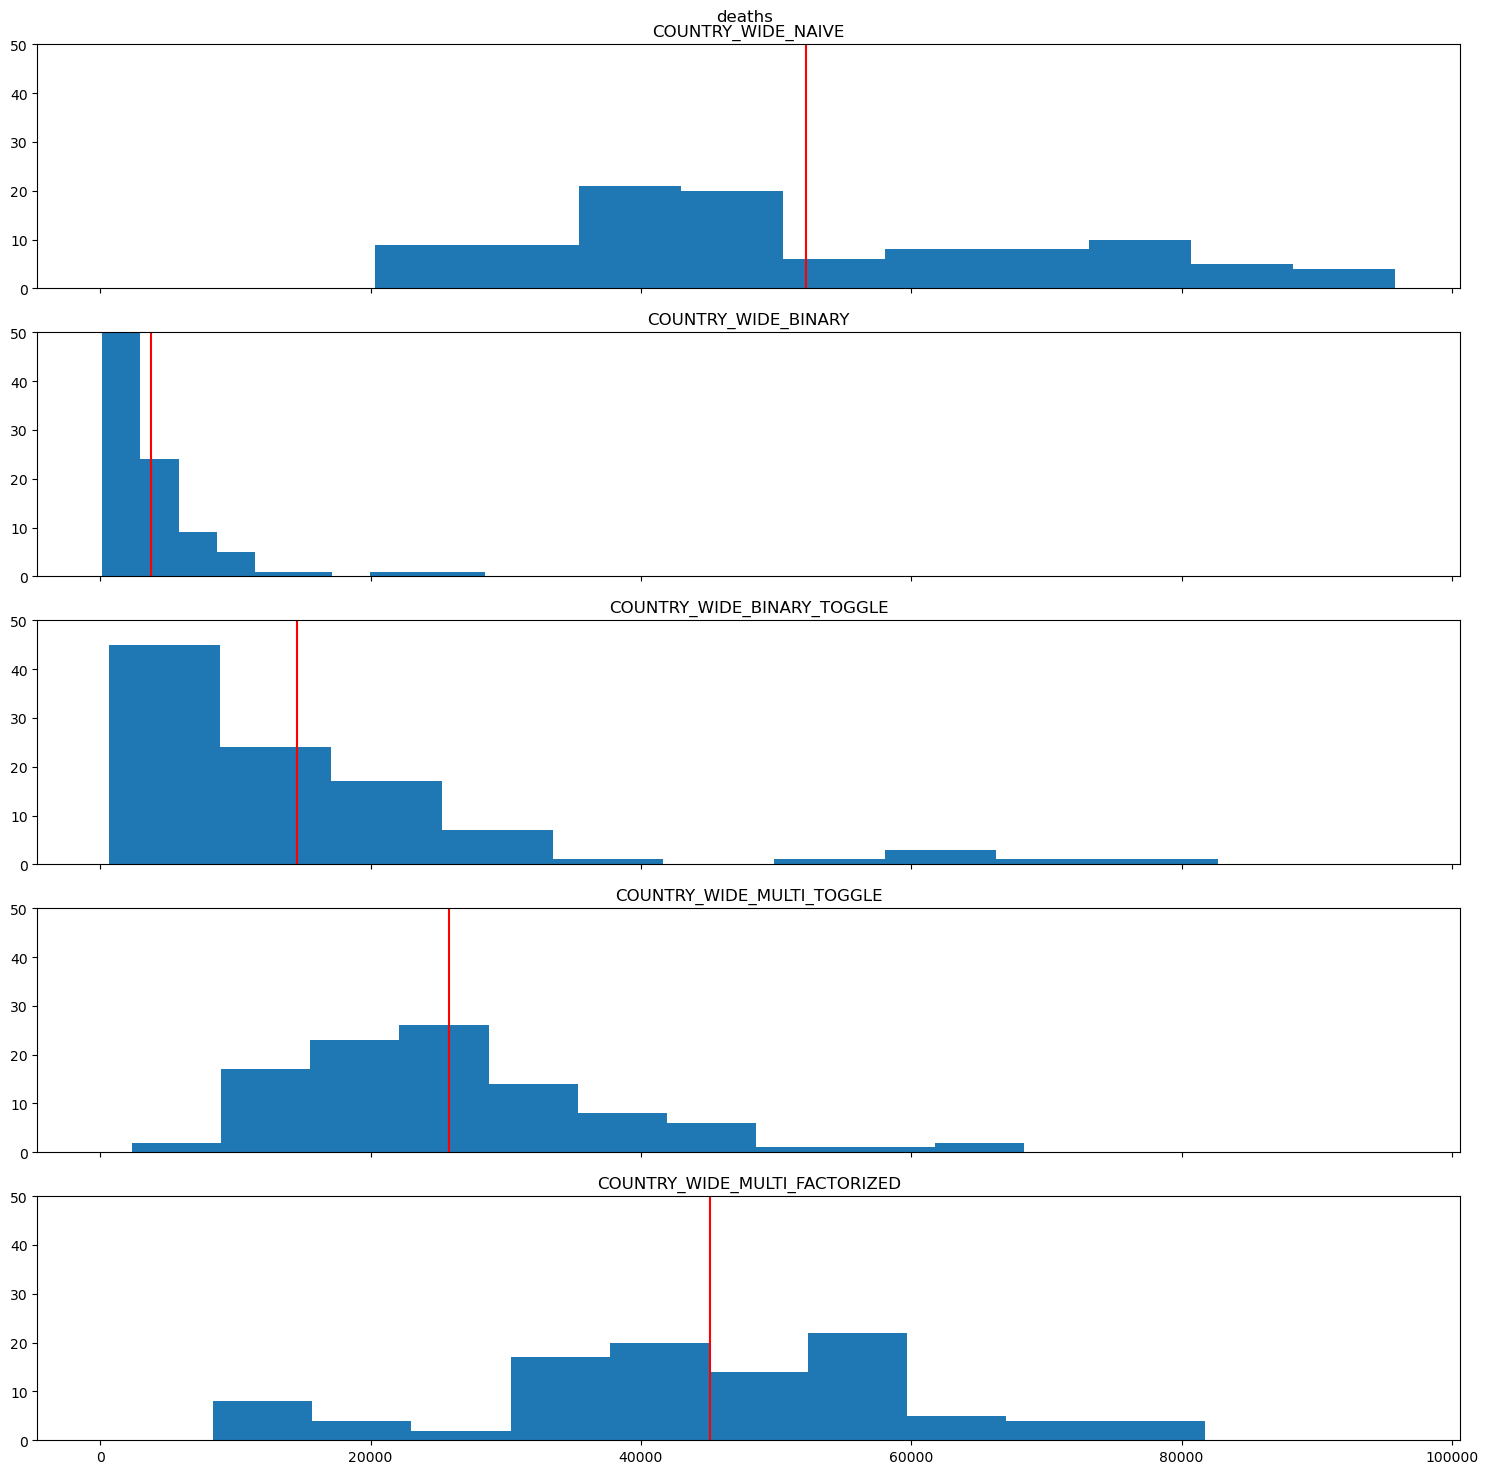

In [10]:
parameters = {key:extract_log_parameters(val) for key, val in run_logs.items()}
show_parameter_hist(parameters,'deaths')

COUNTRY_WIDE_NAIVE : average reward = 16.2
COUNTRY_WIDE_BINARY : average reward = 22.14
COUNTRY_WIDE_BINARY_TOGGLE : average reward = 22.5
COUNTRY_WIDE_MULTI_TOGGLE : average reward = 4.19
COUNTRY_WIDE_MULTI_FACTORIZED : average reward = 0.0


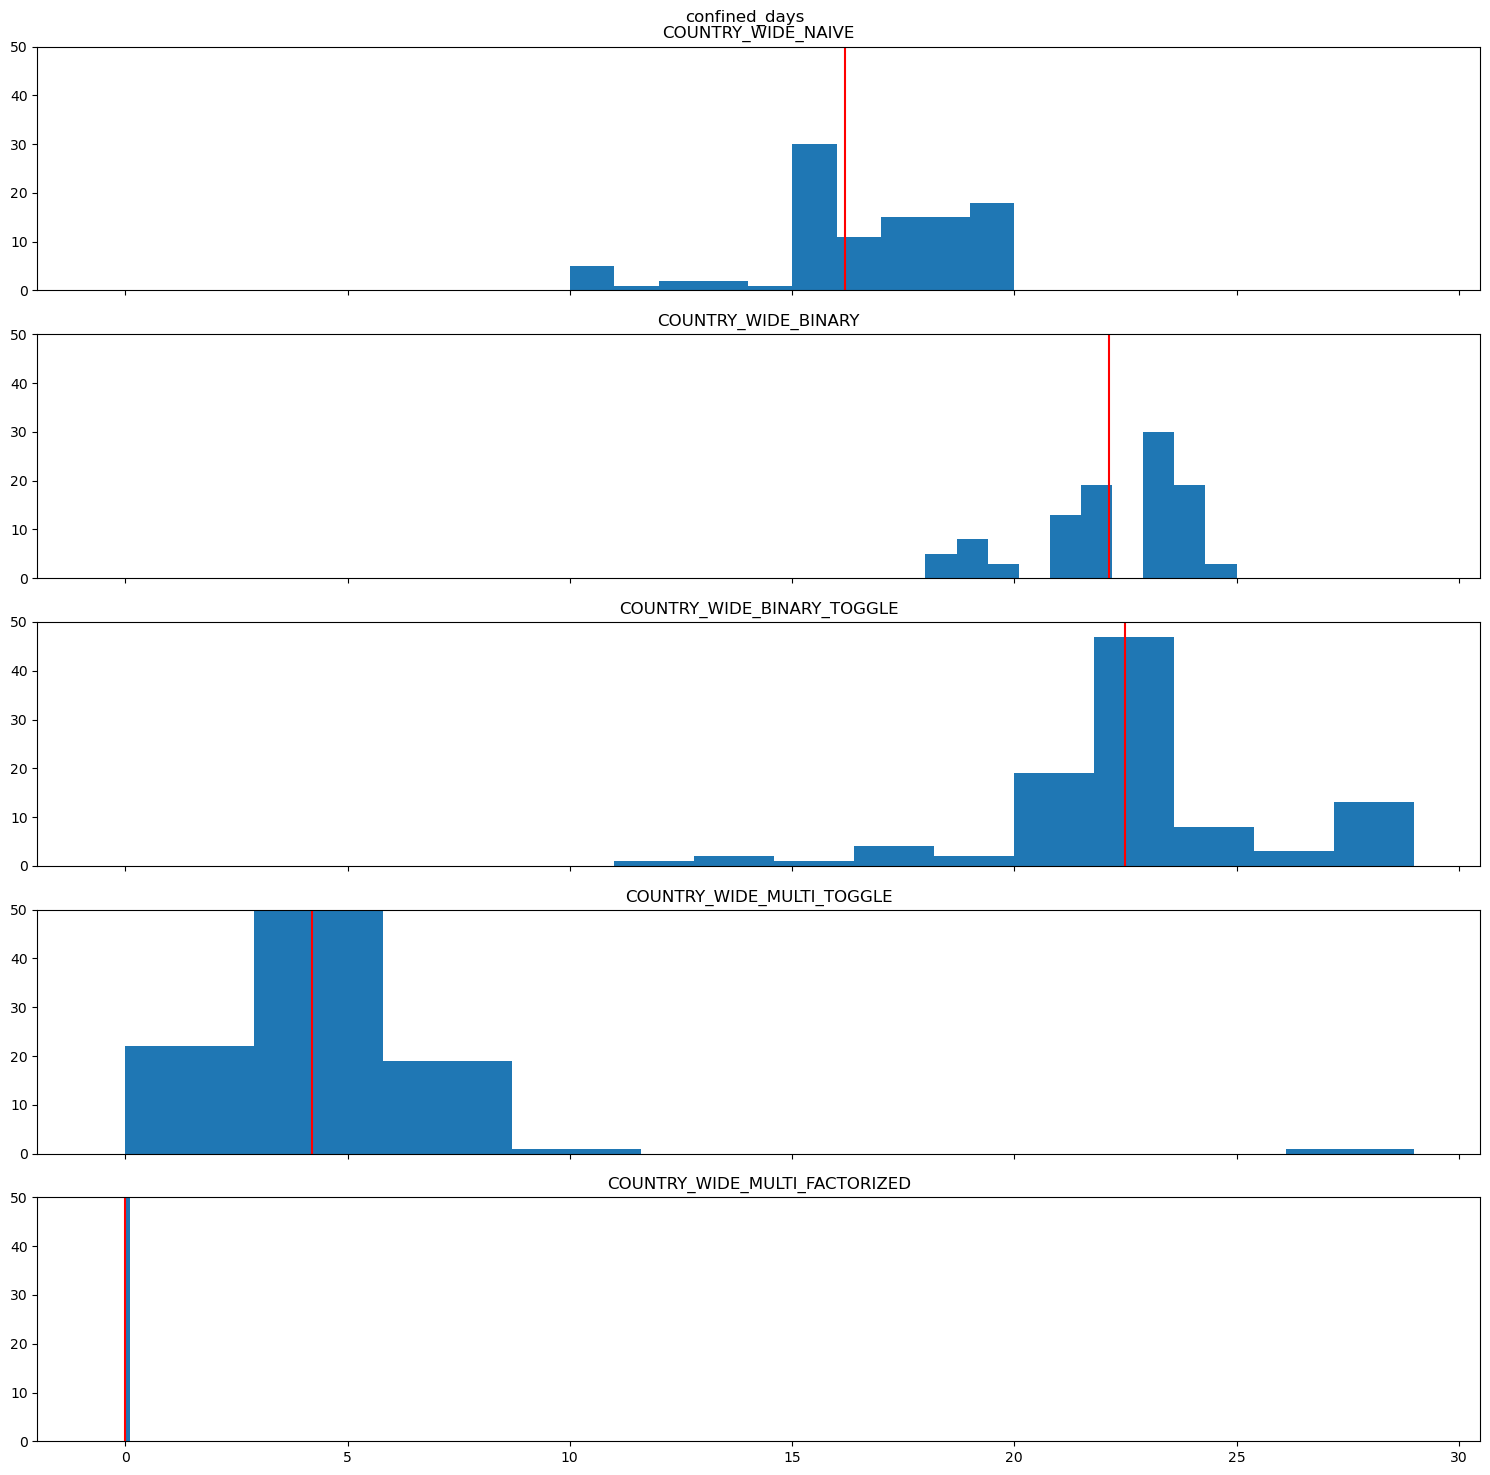

In [13]:
parameters = {key:extract_log_parameters(val) for key, val in run_logs.items()}
show_parameter_hist(parameters,'confined_days')

In [64]:
run_logs.keys()

dict_keys(['COUNTRY_WIDE_NAIVE', 'COUNTRY_WIDE_BINARY', 'COUNTRY_WIDE_BINARY_TOGGLE', 'COUNTRY_WIDE_MULTI_TOGGLE'])

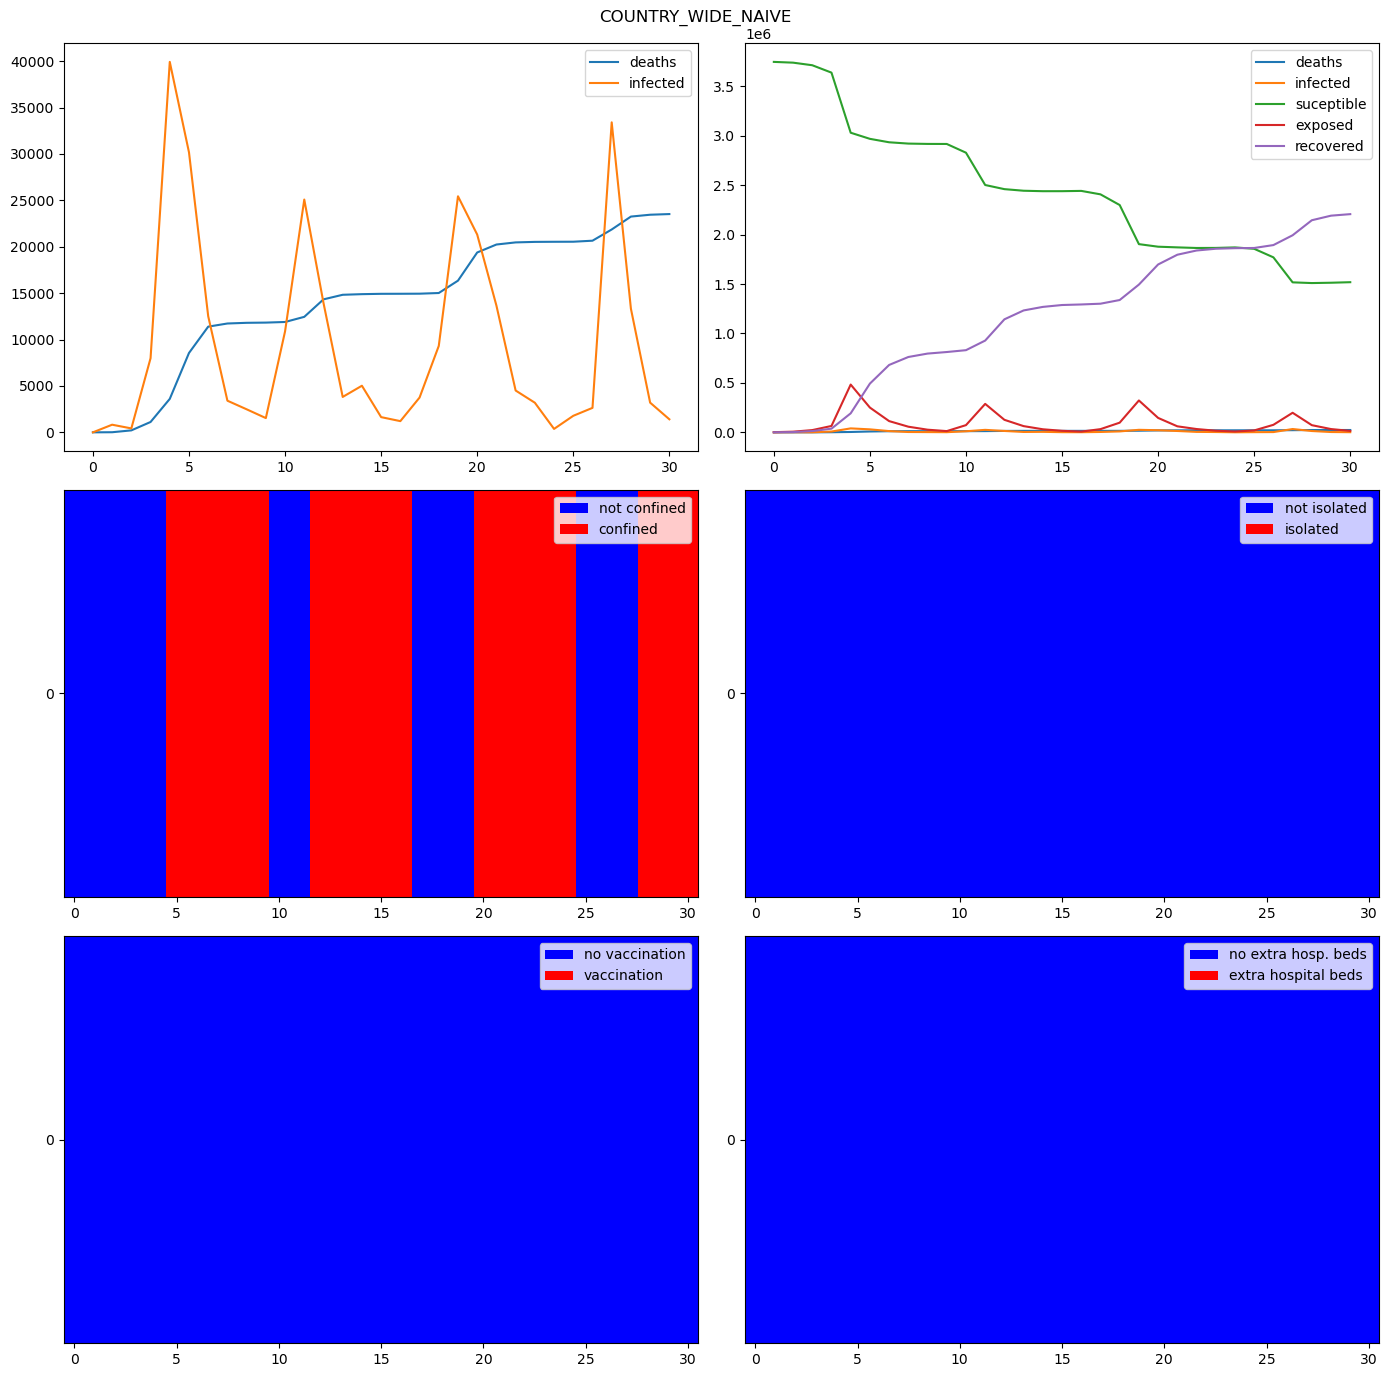

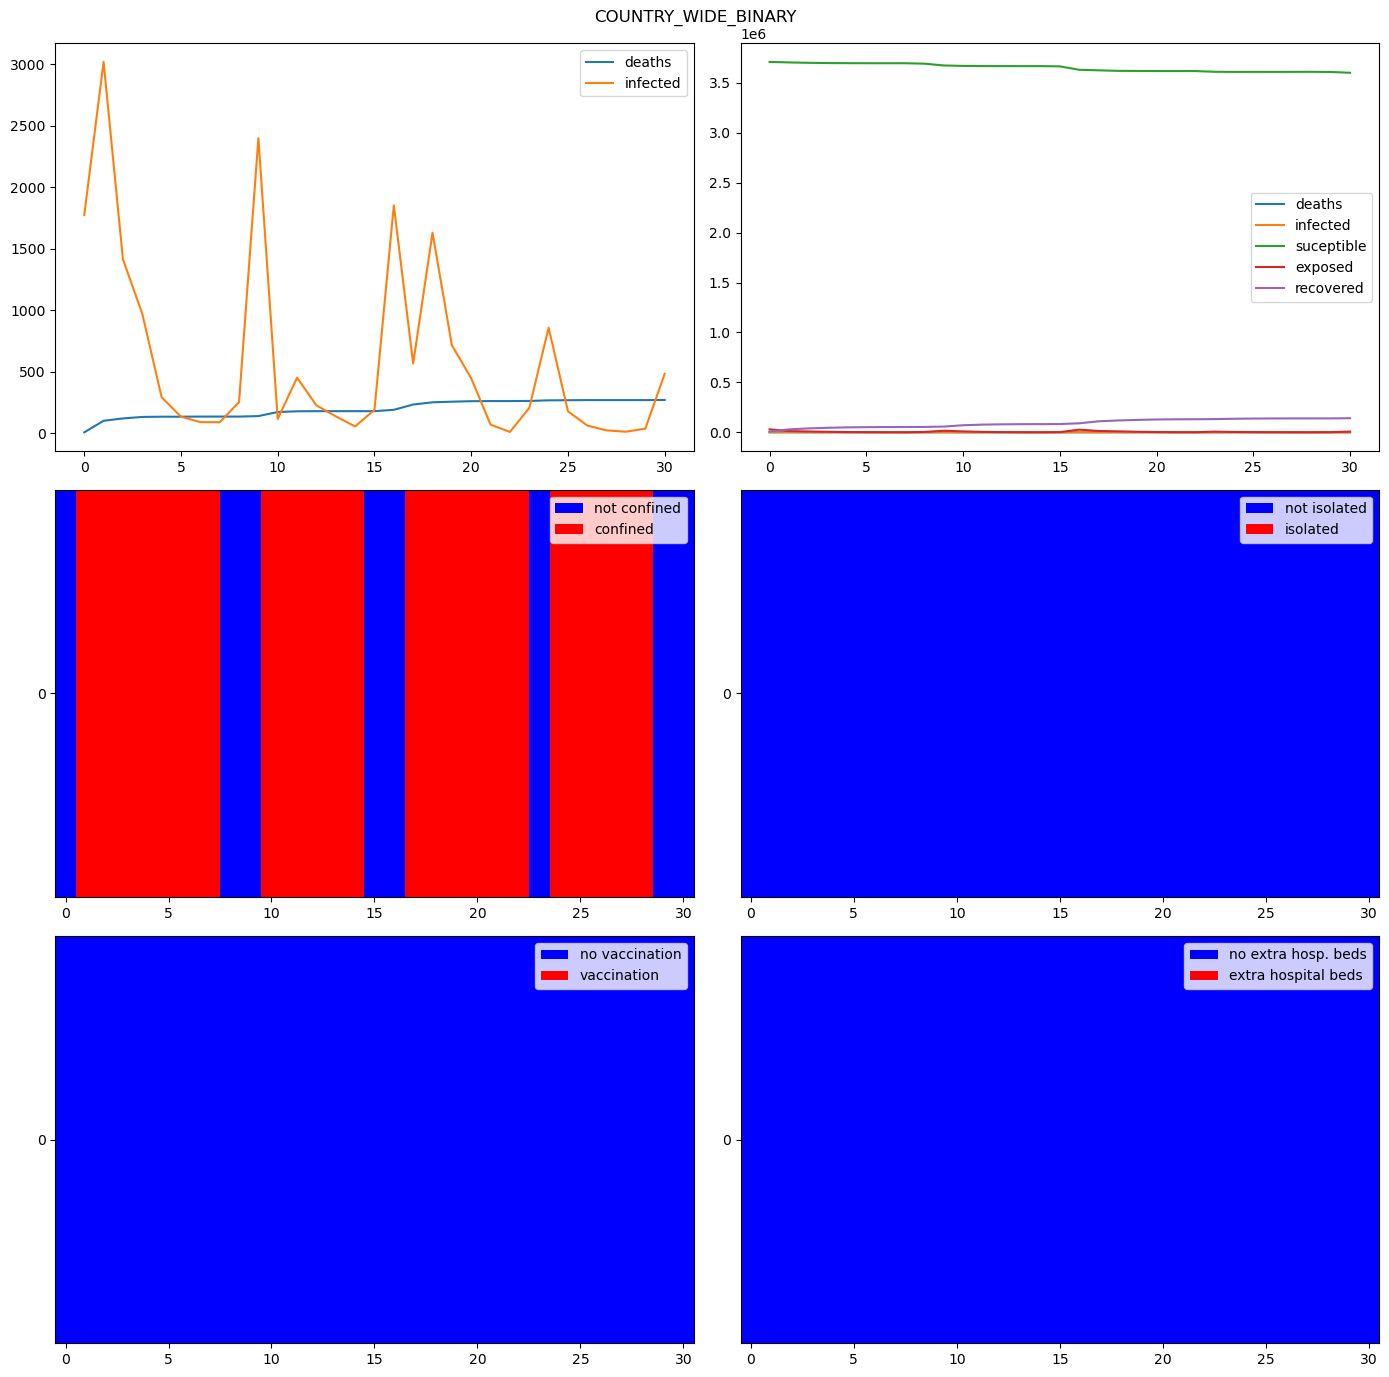

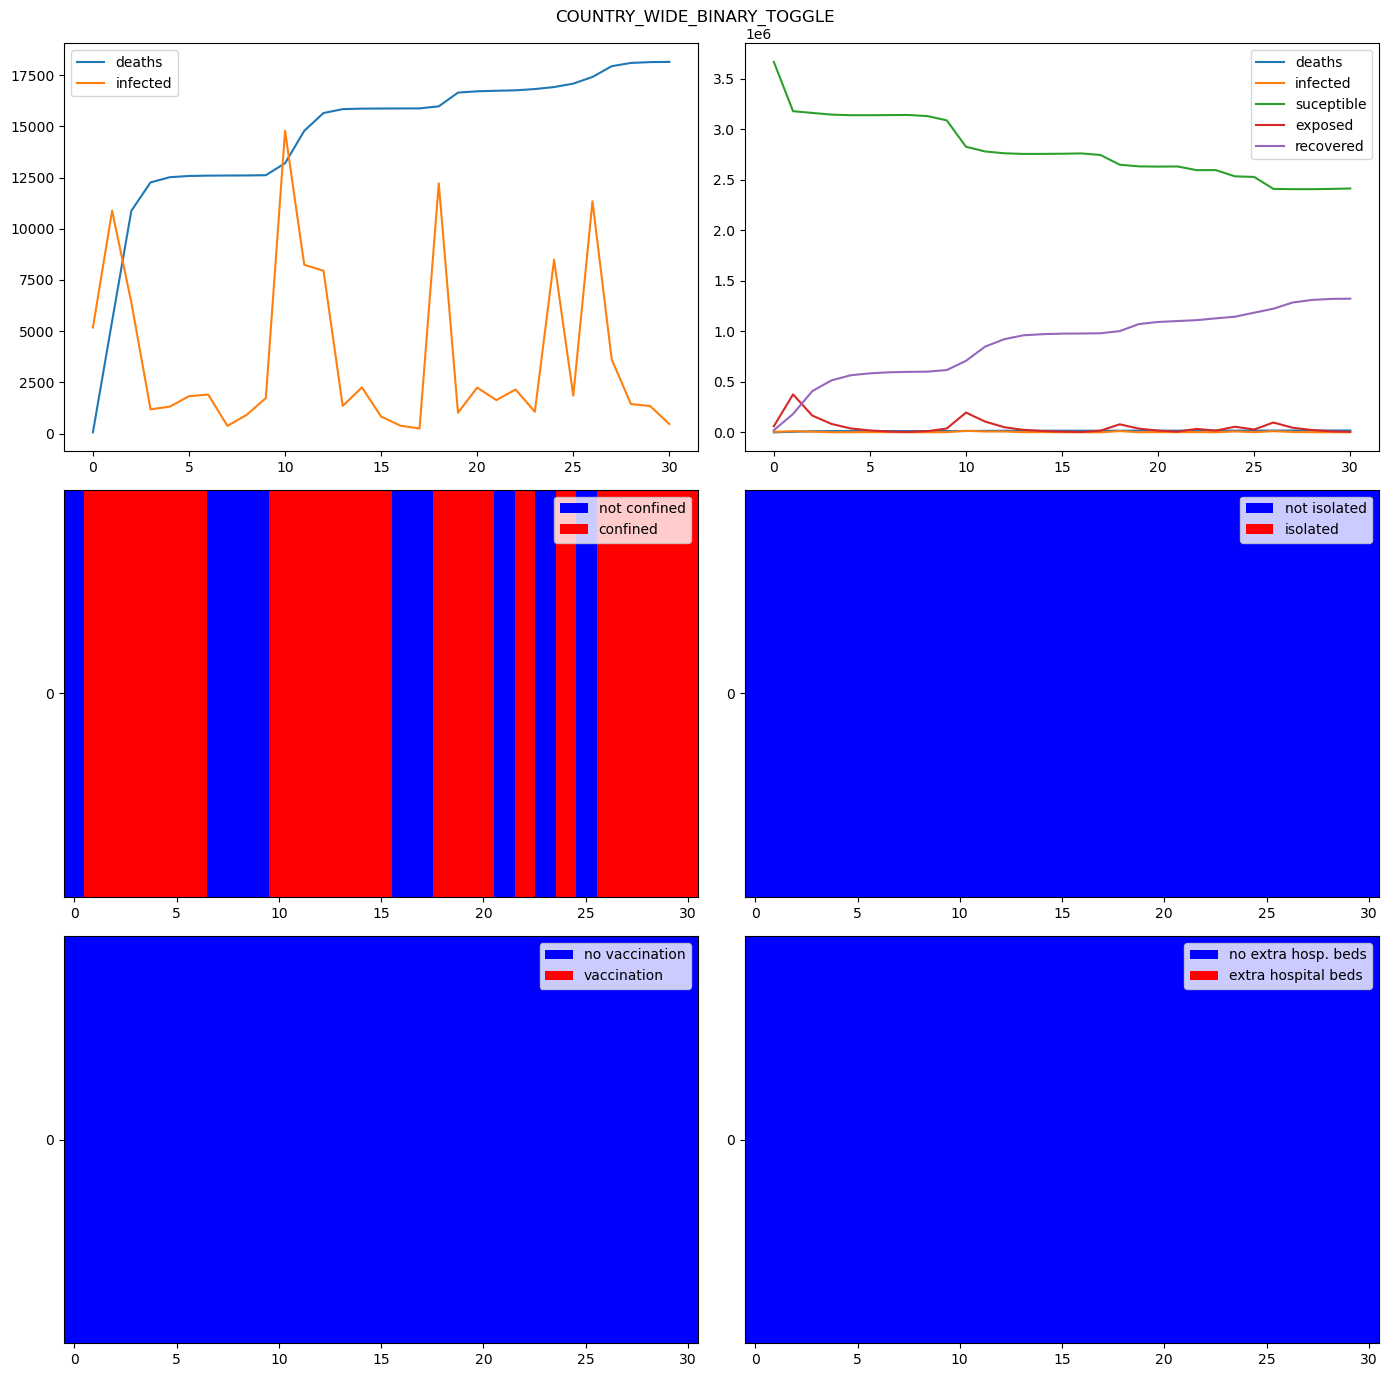

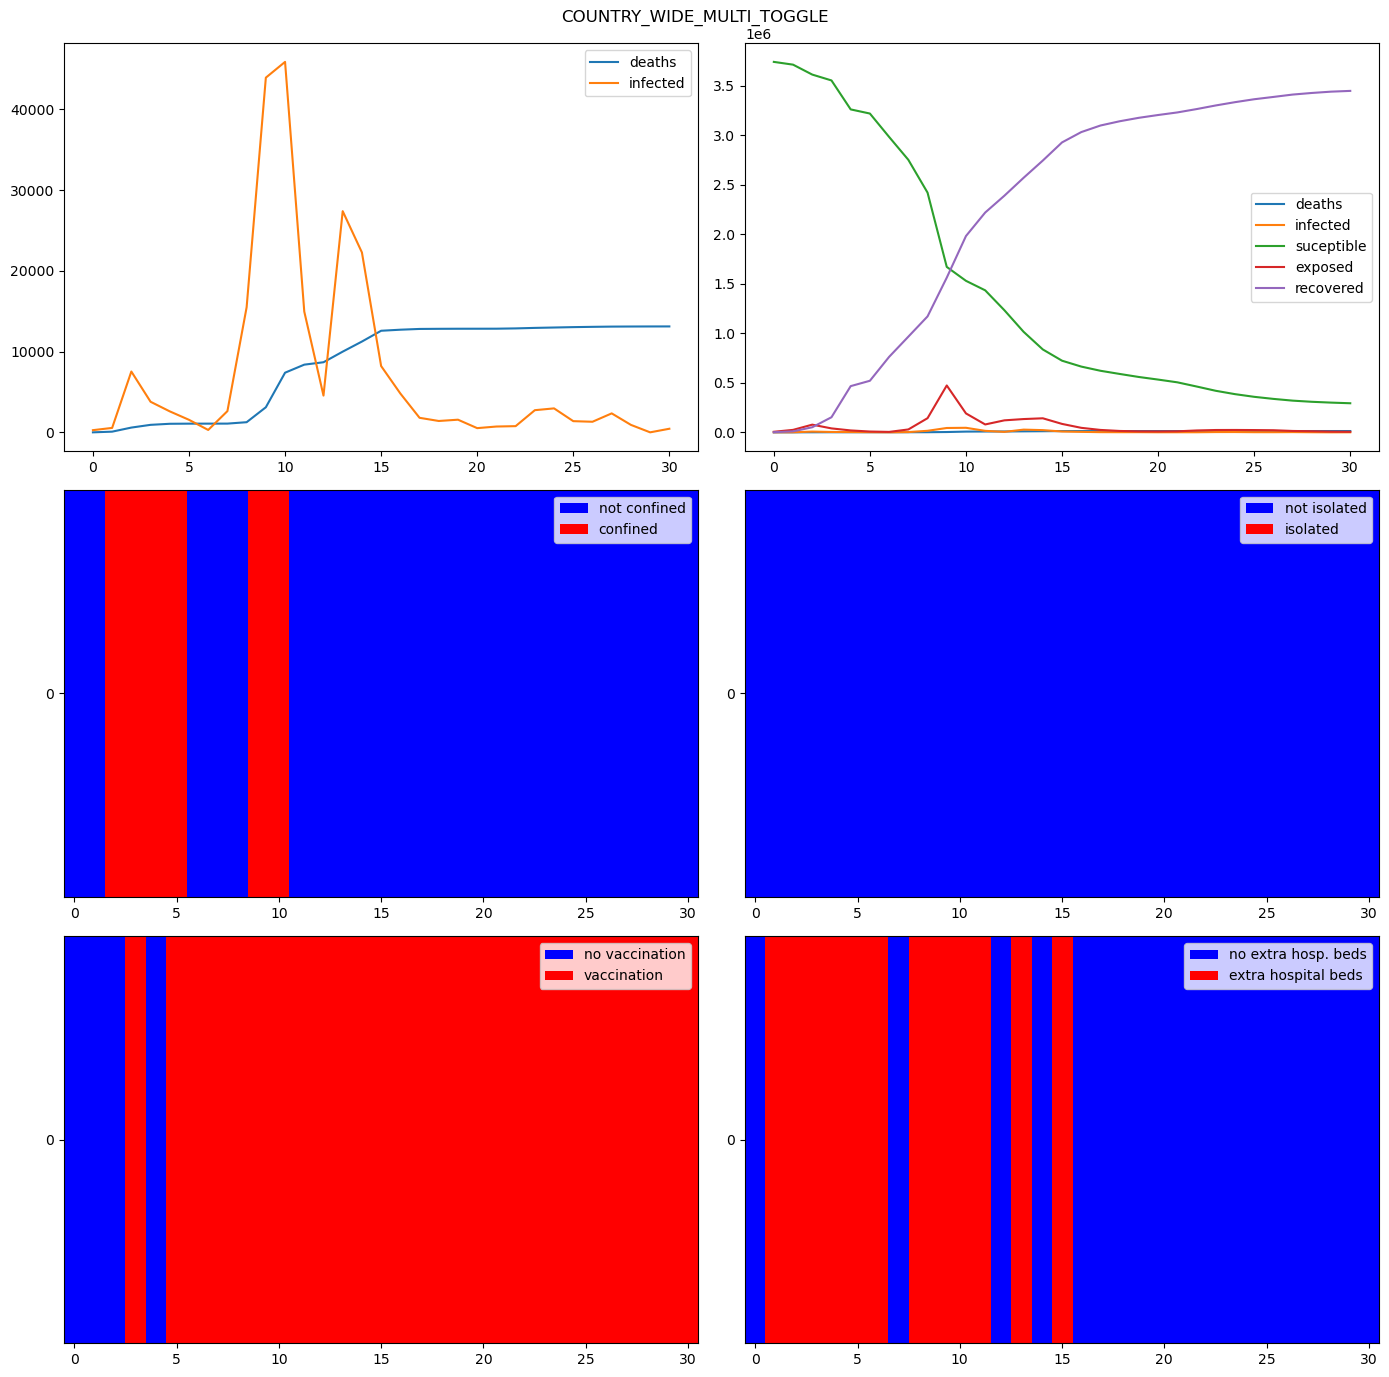

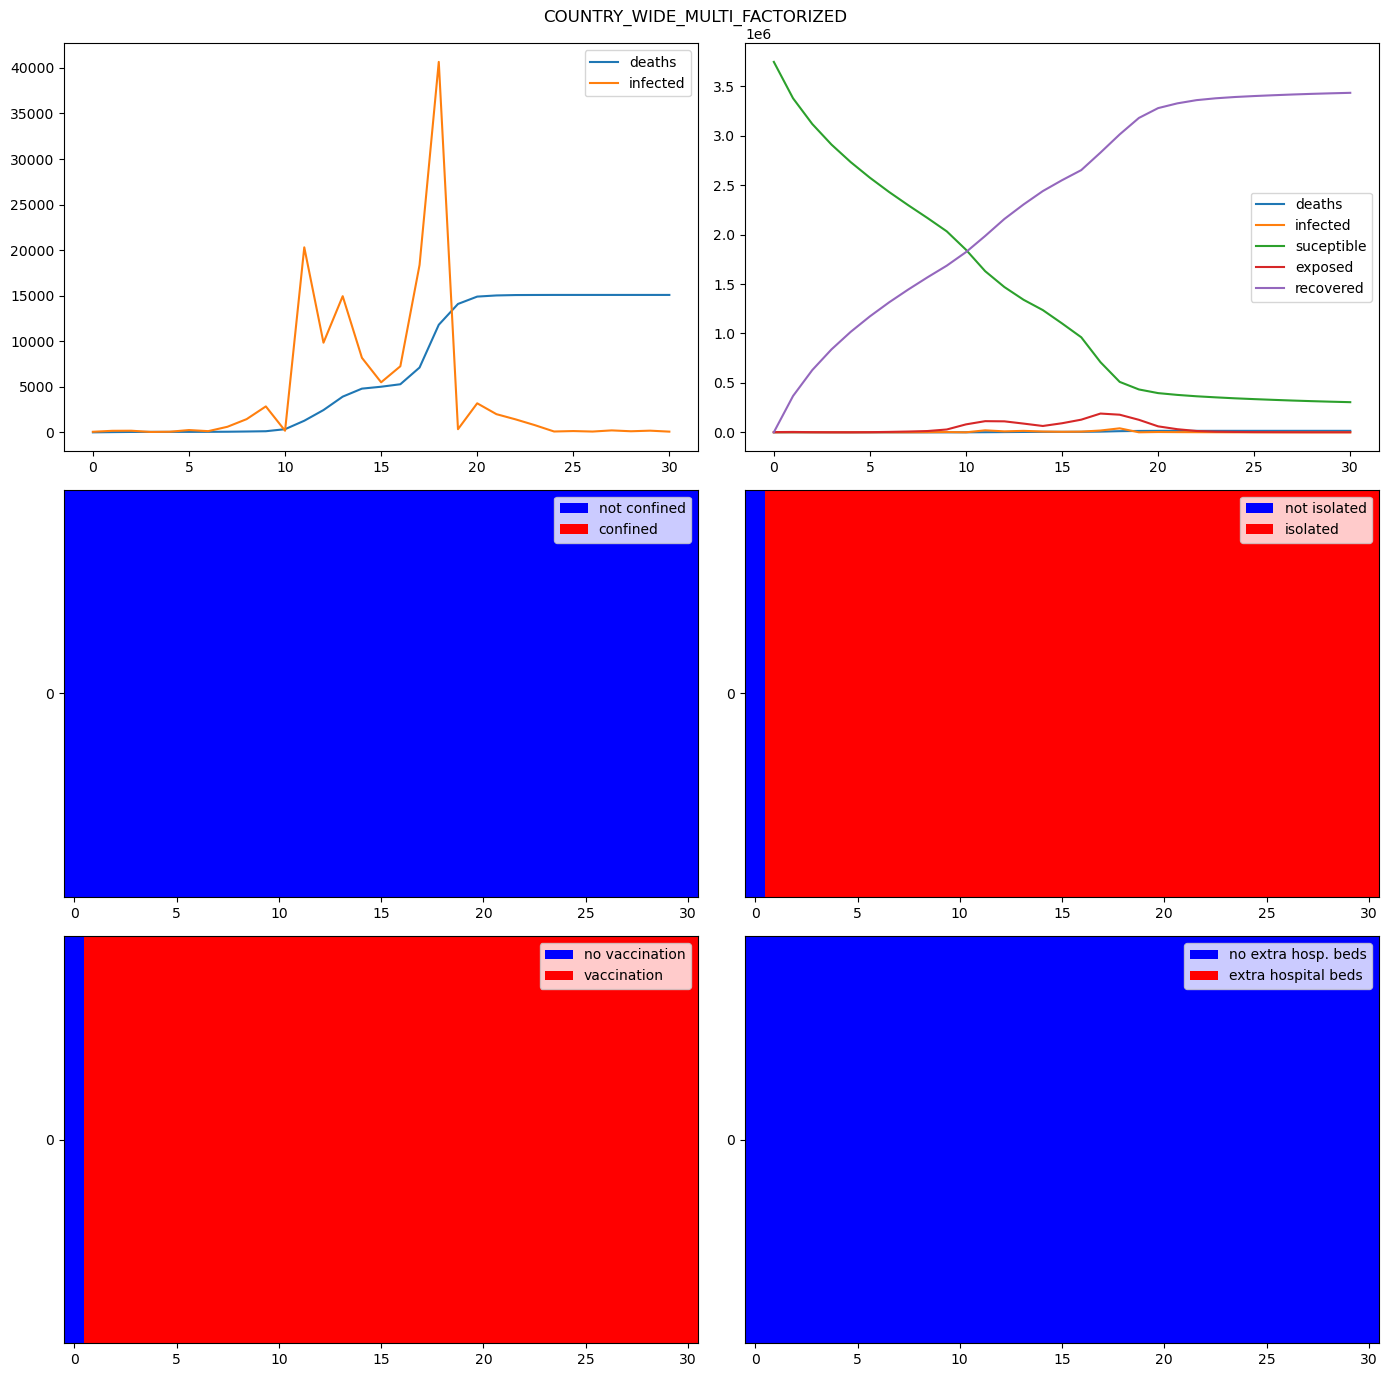

In [14]:
def plot_time_boolean(dataframe, ax, true_label, false_label):
    b_array = np.array(dataframe).transpose()*(1.0)
    ax.imshow(b_array, aspect='auto', interpolation=None,
              cmap='bwr', vmin=0, vmax=1)

    legend_elements = [Patch(facecolor='blue', label=false_label),
                       Patch(facecolor='red', label=true_label), ]

    ax.legend(handles=legend_elements)

    y_label_list = dataframe.columns
    ax.set_yticks(list(range(b_array.shape[0])), y_label_list)


def extract_log_parameters(log):
    suceptible = [
        pd.DataFrame([e['parameters']['total']['suceptible'] for e in logel['info_hist']]) for logel in log
        ]
    exposed = [
        pd.DataFrame([e['parameters']['total']['exposed'] for e in logel['info_hist']]) for logel in log
        ]
    infected = [
        pd.DataFrame([e['parameters']['total']['infected'] for e in logel['info_hist']]) for logel in log
        ]
    deaths = [
        pd.DataFrame([e['parameters']['total']['dead'] for e in logel['info_hist']]) for logel in log
        ]
    recovered = [
        pd.DataFrame([e['parameters']['total']['recovered'] for e in logel['info_hist']]) for logel in log
        ]
    confinement = [
        pd.DataFrame([e['action']['confinement'] for e in logel['info_hist']]) for logel in log
        ]
    isolation = [
        pd.DataFrame([e['action']['isolation'] for e in logel['info_hist']]) for logel in log
        ]
    vaccination = [
        pd.DataFrame([e['action']['vaccinate'] for e in logel['info_hist']]) for logel in log
        ]
    hospital = [
        pd.DataFrame([e['action']['hospital'] for e in logel['info_hist']]) for logel in log
        ]
    
    return {
        'suceptible':suceptible,
        'exposed':exposed,
        'infected':infected,
        'deaths':deaths,
        'recovered':recovered,
        'confinement':confinement,
        'isolation':isolation,
        'vaccination':vaccination,
        'hospital':hospital,
    }
    
def plot_run(key, run_id):
    out = extract_log_parameters(run_logs[key])
    scale = 0.7
    fig, ax = plt.subplots(3,2,figsize=(20*scale,20*scale))

    ax[0,0].plot(out['deaths'][run_id])
    ax[0,0].plot(out['infected'][run_id])
    ax[0,0].legend(['deaths','infected'])
    ax[0,1].plot(out['deaths'][run_id])
    ax[0,1].plot(out['infected'][run_id])
    ax[0,1].plot(out['suceptible'][run_id])
    ax[0,1].plot(out['exposed'][run_id])
    ax[0,1].plot(out['recovered'][run_id])
    ax[0,1].legend(['deaths','infected','suceptible','exposed','recovered'])
    plot_time_boolean(out['confinement'][run_id], ax[1,0], 'confined', 'not confined')
    plot_time_boolean(out['isolation'][run_id], ax[1,1], 'isolated', 'not isolated')
    plot_time_boolean(out['vaccination'][run_id], ax[2,0], 'vaccination', 'no vaccination')
    plot_time_boolean(out['hospital'][run_id], ax[2,1], 'extra hospital beds', 'no extra hosp. beds')
    fig.suptitle(key)
    fig.tight_layout()

plot_run('COUNTRY_WIDE_NAIVE', 5)
plot_run('COUNTRY_WIDE_BINARY', 5)
plot_run('COUNTRY_WIDE_BINARY_TOGGLE', 5)
plot_run('COUNTRY_WIDE_MULTI_TOGGLE', 5)
plot_run('COUNTRY_WIDE_MULTI_FACTORIZED', 5)

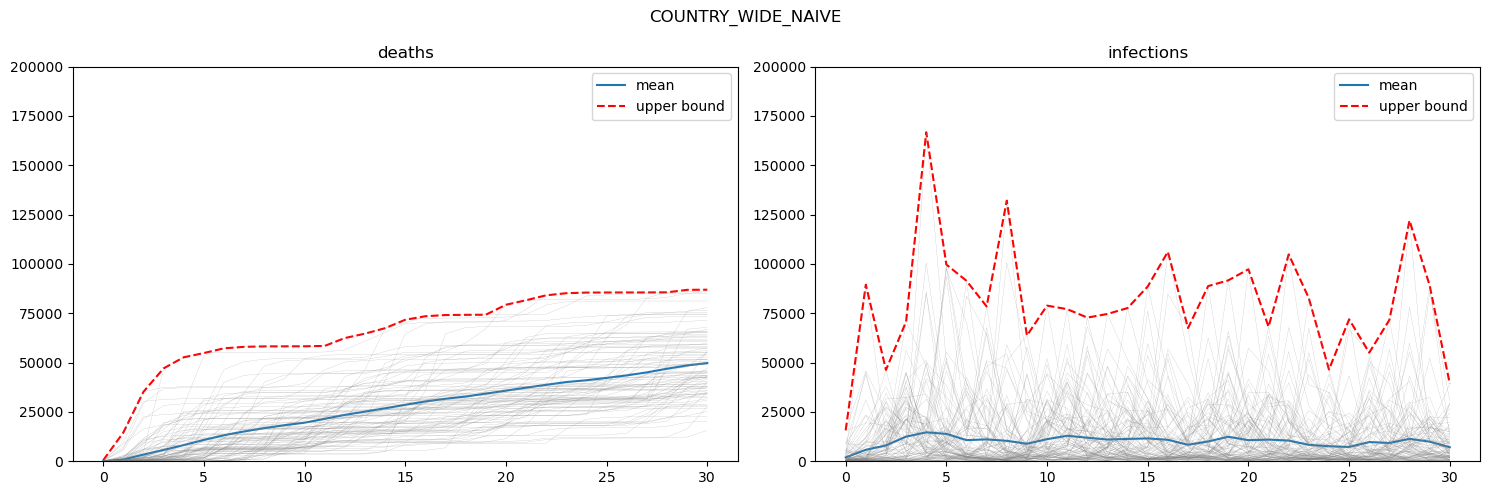

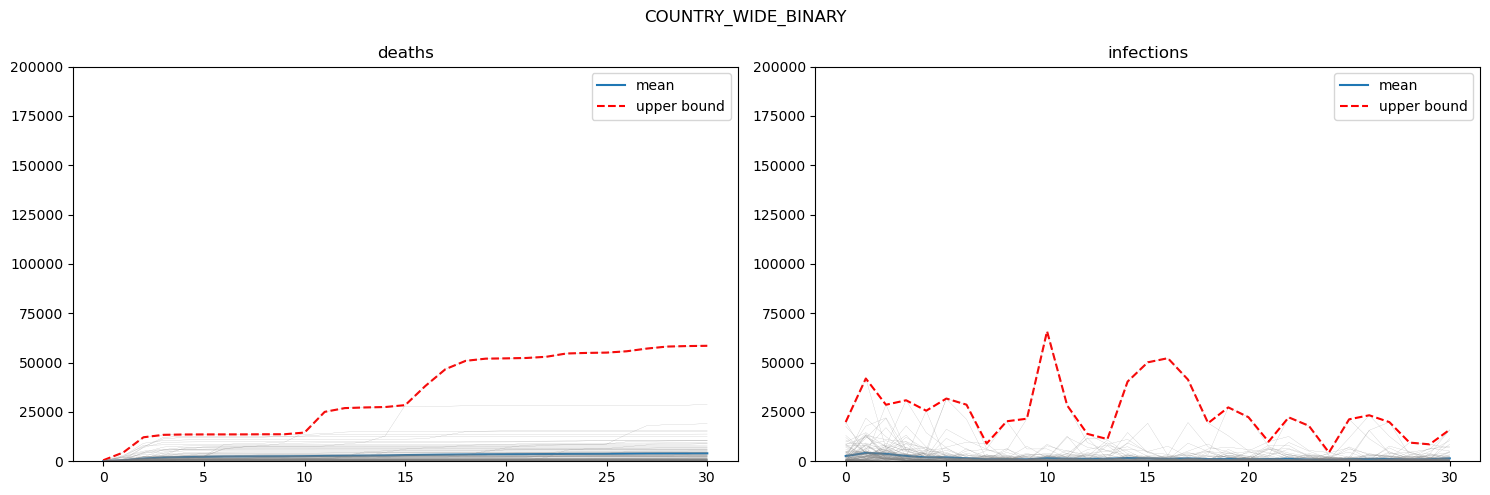

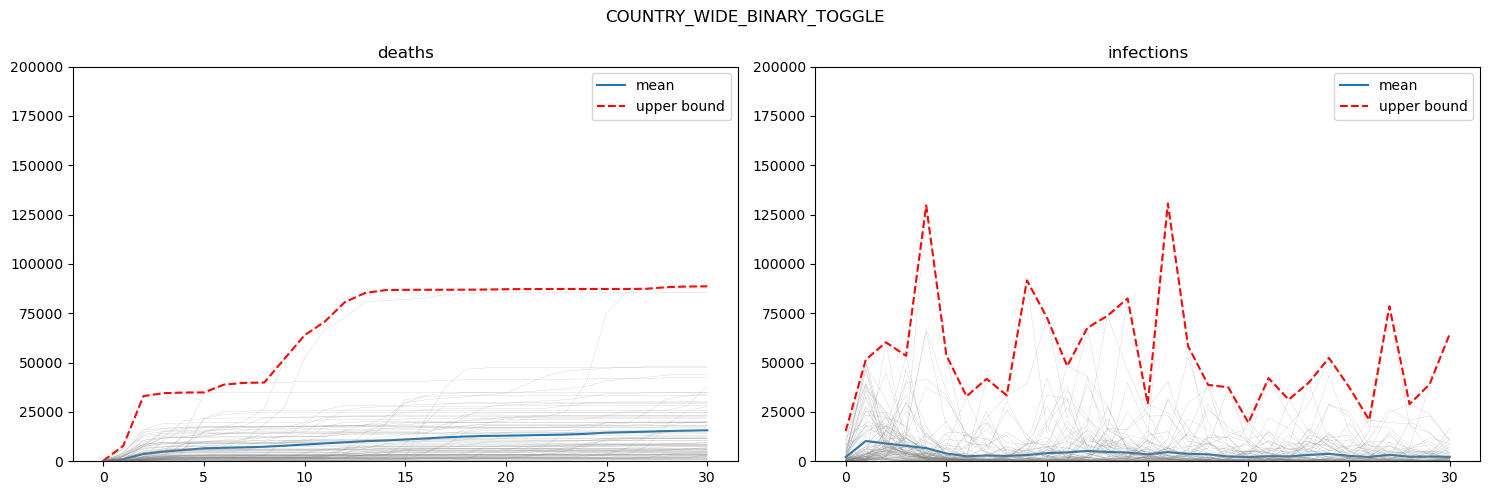

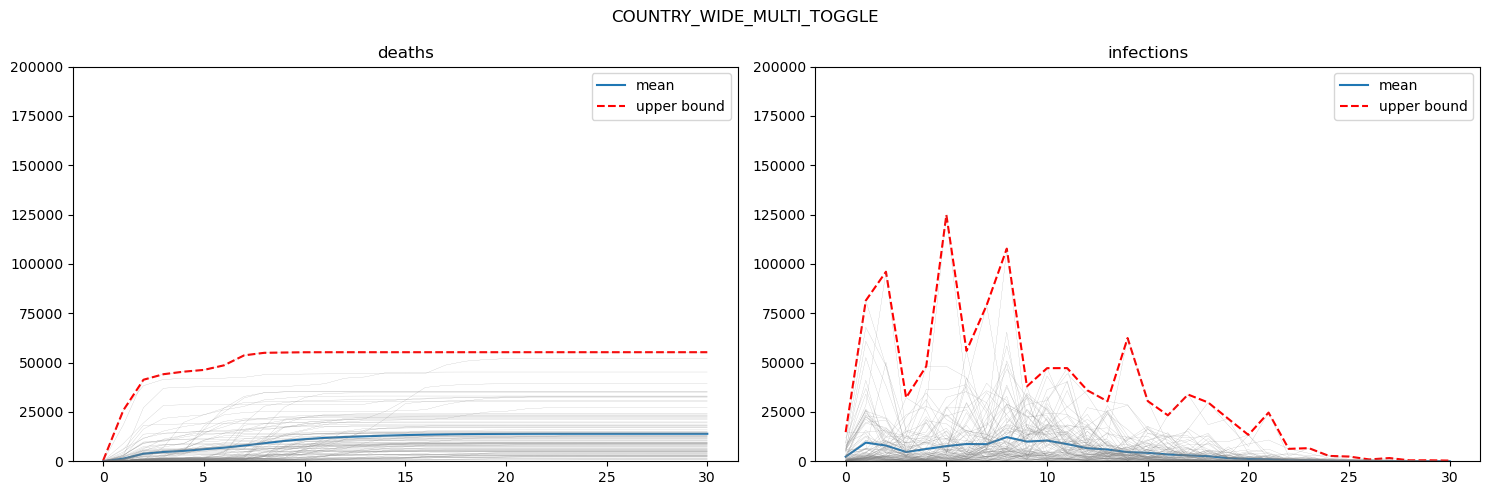

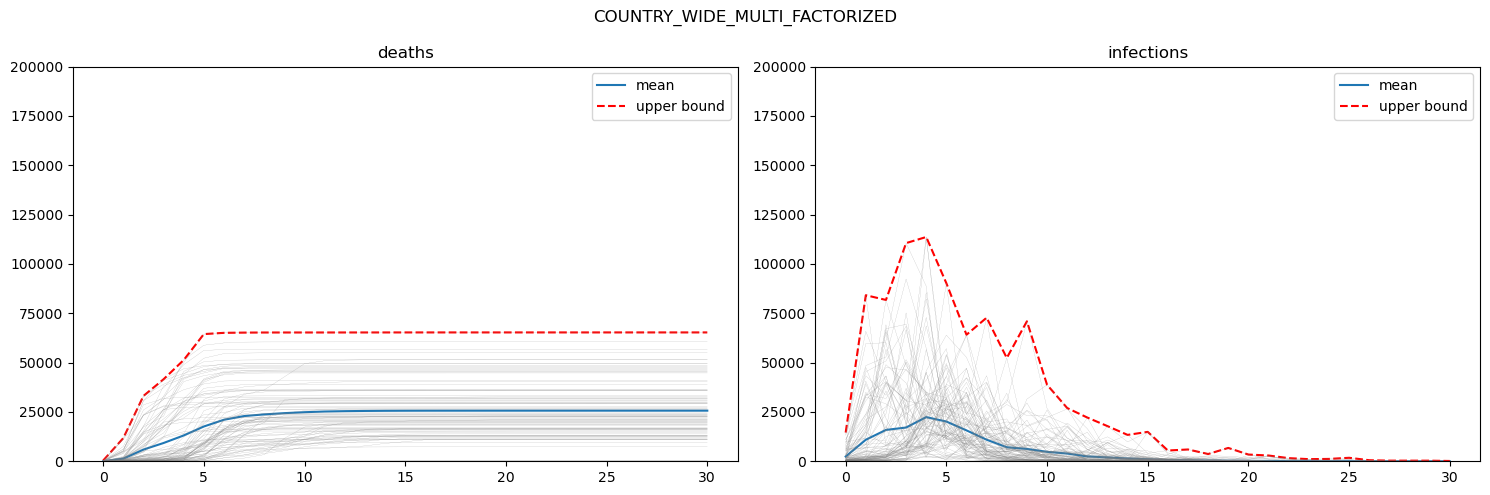

In [17]:
def plot_run_exp_var(key, run_ids):
    out = extract_log_parameters(run_logs[key])
    scale = 1
    fig, ax = plt.subplots(1,2,figsize=(15*scale,5*scale))

    avg_deaths = np.mean([out['deaths'][_id] for _id in run_ids],axis=0)
    deaths_sup = np.max([out['deaths'][_id] for _id in run_ids],axis=0)

    ax[0].plot(avg_deaths)
    ax[0].plot(deaths_sup, '--', color='red')

    ax[0].legend(['mean','upper bound','lower bound'])
    [ax[0].plot(out['deaths'][_id], color='gray', linewidth=0.1) for _id in run_ids]
    ax[0].set_title('deaths')
    ax[0].set_ylim(0,200000)


    avg_infected = np.mean([out['infected'][_id] for _id in run_ids],axis=0)
    infected_sup = np.max([out['infected'][_id] for _id in run_ids],axis=0)
    ax[1].plot(avg_infected)
    ax[1].plot(infected_sup, '--', color='red')

    ax[1].legend(['mean','upper bound','lower bound'])
    [ax[1].plot(out['infected'][_id], color='gray', linewidth=0.1) for _id in run_ids]
    ax[1].set_title('infections')
    ax[1].set_ylim(0,200000)
    fig.suptitle(key)
    fig.tight_layout()
    plt.show()
%matplotlib inline
plot_run_exp_var('COUNTRY_WIDE_NAIVE', range(100))
plot_run_exp_var('COUNTRY_WIDE_BINARY', range(100))
plot_run_exp_var('COUNTRY_WIDE_BINARY_TOGGLE', range(100))
plot_run_exp_var('COUNTRY_WIDE_MULTI_TOGGLE', range(100))
plot_run_exp_var('COUNTRY_WIDE_MULTI_FACTORIZED', range(100))

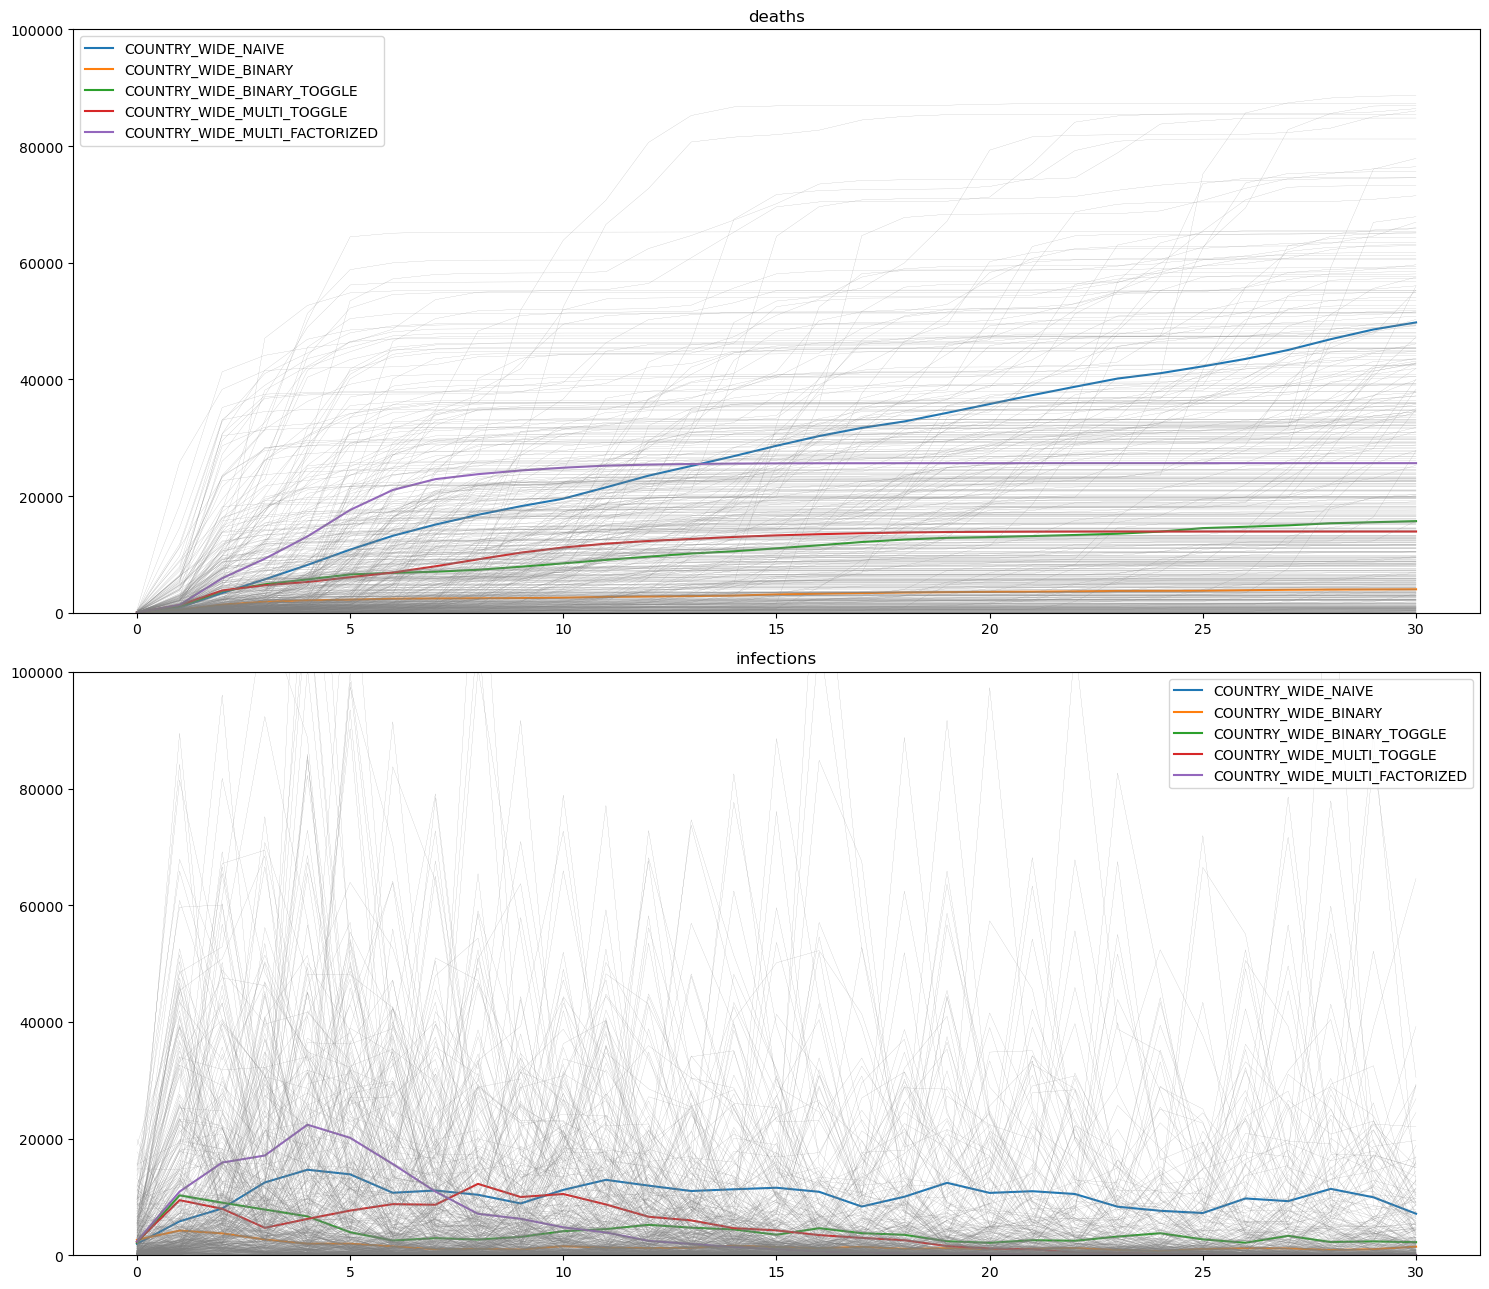

In [18]:

items = [   ('COUNTRY_WIDE_NAIVE', range(100)),
            ('COUNTRY_WIDE_BINARY', range(100)),
            ('COUNTRY_WIDE_BINARY_TOGGLE', range(100)),
            ('COUNTRY_WIDE_MULTI_TOGGLE', range(100)),
            ('COUNTRY_WIDE_MULTI_FACTORIZED', range(100)),]

def plot_runs_exp_var(keys):
    scale = 1
    fig, ax = plt.subplots(2,1,figsize=(15*scale,13*scale))
    ax[0].set_title('deaths')
    ax[1].set_title('infections')
    for k,run_ids in keys:
        out = extract_log_parameters(run_logs[k])

        avg_deaths = np.mean([out['deaths'][_id] for _id in run_ids],axis=0)

        ax[0].plot(avg_deaths)
        ax[0].set_ylim(0,100000)


        avg_infected = np.mean([out['infected'][_id] for _id in run_ids],axis=0)
        ax[1].plot(avg_infected)
        ax[1].set_ylim(0,100000)
    ax[0].legend([e[0] for e in keys])
    ax[1].legend([e[0] for e in keys])
    for k,run_ids in keys:
        out = extract_log_parameters(run_logs[k])
        [ax[0].plot(out['deaths'][_id], color='gray', linewidth=0.1) for _id in run_ids]
        [ax[1].plot(out['infected'][_id], color='gray', linewidth=0.1) for _id in run_ids]
    fig.tight_layout()
    plt.show()
plot_runs_exp_var(items)